In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, MDS

import networkx as nx
import graphviz
import pydotplus
from networkx.drawing.nx_pydot import graphviz_layout

# Load data and replace outliers with the max value

In [5]:
df = pd.read_csv("data/bdata.2009.tsv.csv")

df.loc[df.meas > 50000, "meas"] = 50000
df.meas = 1 - np.log(df.meas) / np.log(50000)
bind_threshold = 1 - np.log(500) / np.log(50000)

df.loc[df.mhc == "HLAA1", "mhc"] = "HLAA0101"
df.loc[df.mhc == "HLAA11", "mhc"] = "HLAA0101"
df.loc[df.mhc == "HLAA2", "mhc"] = "HLAA0201"
df.loc[df.mhc == "HLAA3", "mhc"] = "HLAA0319"
df.loc[df.mhc == "HLAA3/11", "mhc"] = "HLAA0319"
df.loc[df.mhc == "HLAA26", "mhc"] = "HLAA2602"
df.loc[df.mhc == "HLAA24", "mhc"] = "HLAA2403"

df.loc[df.mhc == "HLAB44", "mhc"] = "HLAB4402"
df.loc[df.mhc == "HLAB51", "mhc"] = "HLAB5101"
df.loc[df.mhc == "HLAB7", "mhc"] = "HLAB0702"
df.loc[df.mhc == "HLAB27", "mhc"] = "HLAB2720"
df.loc[df.mhc == "HLAB8", "mhc"] = "HLAB0801"

df.loc[df.mhc == "HLACw1", "mhc"] = "HLAC0401"
df.loc[df.mhc == "HLACw4", "mhc"] = "HLAC0401"

df = df.loc[df.mhc != "HLAB60", :]

# Load the ProtVec model

In [6]:
protvec_df = pd.read_table("data/protvec.csv", sep = "\\t", header=None)
protvec = {}
for ind, row in protvec_df.iterrows():
    row = list(row)
    row[0] = row[0][1:]
    row[-1] = row[-1][:-1]
    protvec[row[0]] = np.array(row[1:], dtype=float)

/home/vdn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [7]:
def pv_vec(seq, protvec=protvec):
    res = np.zeros((100, len(seq) - 2), dtype=float)
    for i in range(len(seq) - 2):
        res[:, i] = protvec[seq[i:i+3]]
    return res


def pv_sum(seq, protvec=protvec):
    res = np.zeros((100,), dtype=float)
    for i in range(len(seq) - 2):
        res += protvec[seq[i:i+3]]
    return res

# Load MHC sequences

In [8]:
mhc_df = pd.read_csv("data/mhc_seq_imghtla.csv")
list(mhc_df.mhc)

['HLAA0201',
 'HLAA0211',
 'HLAA2402',
 'HLAA8001',
 'HLAA3001',
 'HLAA0202',
 'HLAA0101',
 'HLAA2301',
 'HLAA2603',
 'HLAA6801',
 'HLAA3101',
 'HLAA3201',
 'HLAA2403',
 'HLAA0207',
 'HLAA3301',
 'HLAA0319',
 'HLAA0216',
 'HLAA0217',
 'HLAA0203',
 'HLAA1101',
 'HLAA2602',
 'HLAA0210',
 'HLAA6823',
 'HLAA7401',
 'HLAA2501',
 'HLAA0219',
 'HLAA0206',
 'HLAA2902',
 'HLAA1102',
 'HLAA3215',
 'HLAA0302',
 'HLAA0212',
 'HLAA6901',
 'HLAA0301',
 'HLAA3002',
 'HLAA6601',
 'HLAA2601',
 'HLAA0250',
 'HLAA0204',
 'HLAA6802',
 'HLAA3207',
 'HLAA0205',
 'HLAB8301',
 'HLAB5802',
 'HLAB2701',
 'HLAB1503',
 'HLAB4801',
 'HLAB3501',
 'HLAB1401',
 'HLAB4403',
 'HLAB4601',
 'HLAB2702',
 'HLAB1501',
 'HLAB5201',
 'HLAB5301',
 'HLAB1509',
 'HLAB0803',
 'HLAB0802',
 'HLAB7301',
 'HLAB3901',
 'HLAB2710',
 'HLAB3701',
 'HLAB5801',
 'HLAB4002',
 'HLAB4201',
 'HLAB2704',
 'HLAB5401',
 'HLAB2705',
 'HLAB5101',
 'HLAB5701',
 'HLAB5702',
 'HLAB4001',
 'HLAB4402',
 'HLAB4013',
 'HLAB4506',
 'HLAB1402',
 'HLAB1542',

# tSNE on MHC

In [9]:
human_df = df.loc[df.species == "human", :]
human_df.shape

(151928, 7)

In [10]:
human_peptide = np.zeros((human_df.shape[0], 100), dtype=np.float)
for i, pep in enumerate(human_df.sequence):
    human_peptide[i, :] = pv_sum(pep)

In [11]:
# this is madness. MADNESS!!!
human_mhc = np.zeros((human_df.shape[0], 100), dtype=np.float)
for i, mhc_name in enumerate(human_df.mhc):
    try:
        human_mhc[i, :] = pv_sum(mhc_df.sequence[mhc_df.mhc == mhc_name].iloc[0])
    except Exception:
        print(human_df.iloc[i])

In [12]:
human_data = np.hstack([human_peptide, human_mhc])
human_data.shape

(151928, 200)

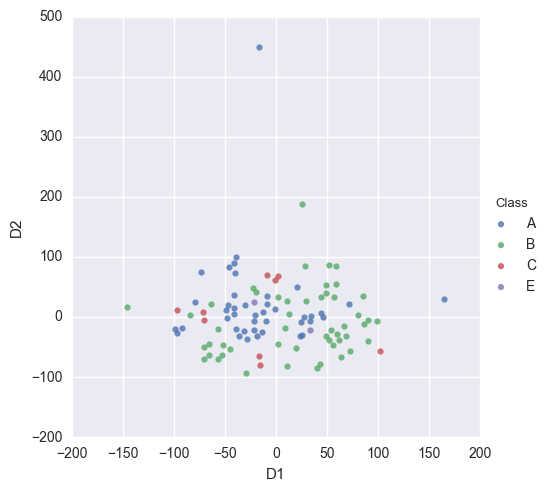

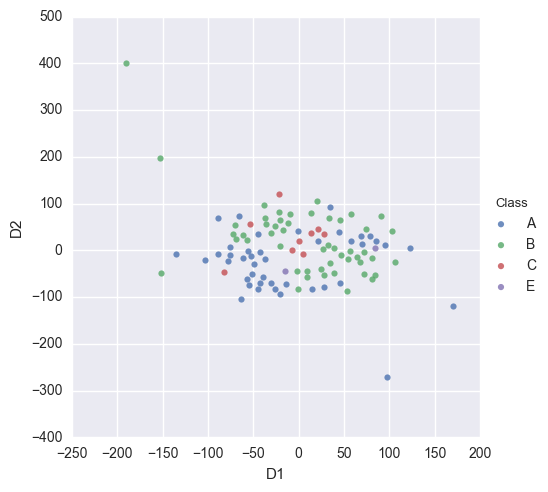

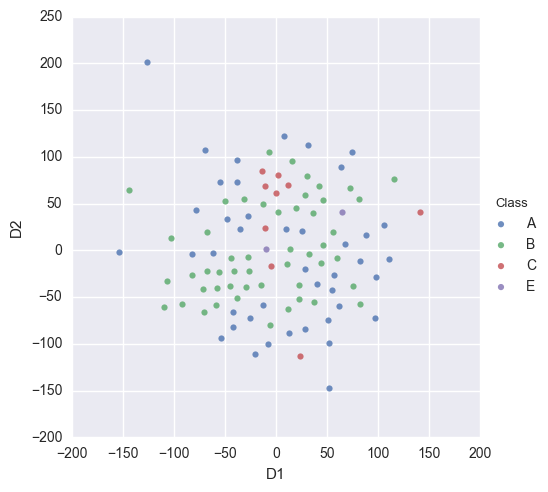

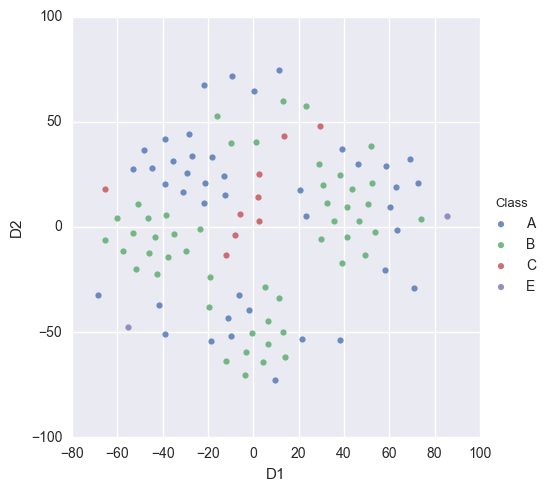

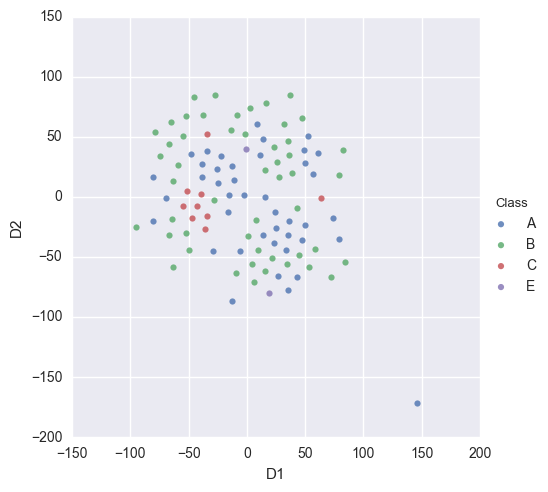

In [44]:
def compute_tsne(perp, data, classes):
    tsne = TSNE(perplexity=perp)
    vec_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame({"D1": vec_tsne[:,0], "D2": vec_tsne[:,1], "Class": classes})
    return sns.lmplot("D1", "D2", hue = "Class", data = df_tsne, fit_reg = False)


new_col = []
for i, mhc_name in enumerate(mhc_df.mhc):
    new_col.append(pv_sum(list(mhc_df.sequence[mhc_df.mhc == mhc_name])[0]))
    

classes = list(map(lambda x: x[3], mhc_df.mhc))
compute_tsne(7, new_col, classes)
compute_tsne(15, new_col, classes)
compute_tsne(25, new_col, classes)
compute_tsne(30, new_col, classes)
compute_tsne(35, new_col, classes)

# MHC network

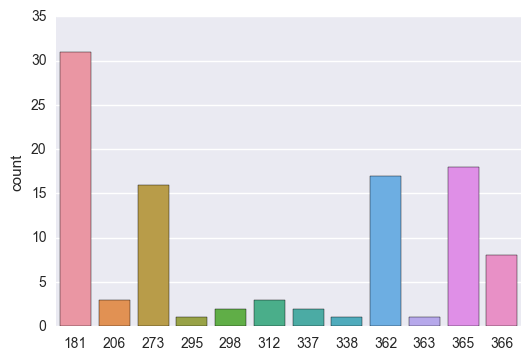

In [45]:
sns.countplot(list(map(len, mhc_df.sequence)))

In [13]:
mhc_df.sequence = list(map(lambda x: x[:180], mhc_df.sequence))

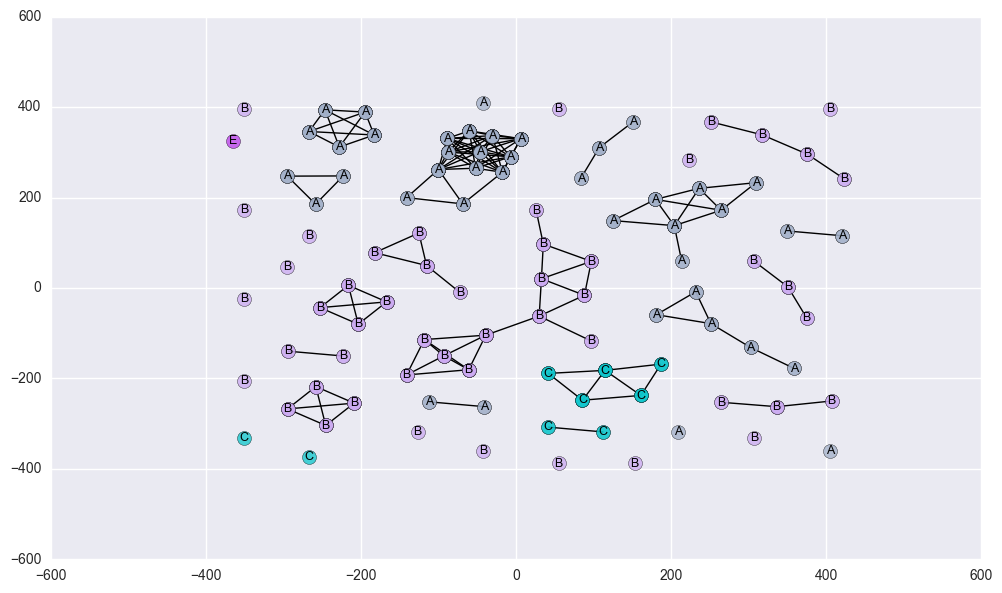

In [47]:
import random


def hamm_check(alpha, beta, max_dist):
    err = 0
    for a, b in zip(alpha, beta):
        err += a != b
        if err >= max_dist:
            return False
    return True
    

MAX_DIST = 10

G = nx.Graph()

mhc_classes = list(map(lambda x: x[3], mhc_df.mhc))

edges = []
labels = {}
color_classes = {x: random.random() for x in mhc_classes}
colors = {x: [] for x in color_classes}
nodes = {x: [] for x in color_classes}

for i in range(len(mhc_df) - 1):
    for j in range(i, len(mhc_df)):
        if hamm_check(mhc_df.sequence.iloc[i], mhc_df.sequence.iloc[j], MAX_DIST):
            edges.append((i, j))
            labels[i] = mhc_classes[i]
            labels[j] = mhc_classes[j]
            colors[mhc_classes[i]].append(colors_classes[mhc_classes[i]])
            colors[mhc_classes[j]].append(colors_classes[mhc_classes[j]])
            nodes[mhc_classes[i]].append(i)
            nodes[mhc_classes[j]].append(j)
            G.add_edge(i, j)

plt.figure(1, figsize=(12, 7))
pos = graphviz_layout(G, prog="neato")
for ag in color_classes:
    nx.draw_networkx_nodes(G, 
                           pos,
                           nodes[ag],
                           node_color=[random.random(), random.random(), random.random()], 
                           node_size = 100, 
                           alpha = .5)
nx.draw_networkx_labels(G, 
                        pos, 
                        labels, 
                        font_size = 9)
nx.draw_networkx_edges(G, pos)

In [11]:
tra_X = human_data
tra_y = human_df.meas

In [27]:
import xgboost as xgb
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

cross_val_score(X=human_data, y=human_df.meas, estimator=xgb.XGBRegressor(nthread=14), cv=3, scoring="mean_squared_error")

array([ -2.66809217e+08,  -3.06861745e+08,  -2.34529082e+08])

In [22]:
mean_squared_error

(151928, 200)